In [109]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn_pandas import DataFrameMapper
from sklearn.model_selection import train_test_split


import torch
import torchtuples as tt

from pycox.datasets import support
from pycox.preprocessing.feature_transforms import OrderedCategoricalLong
from pycox.models import LogisticHazard
from pycox.evaluation import EvalSurv

In [110]:
# ---------------------
# Step 1: Data Creation
# ---------------------

# Parameters for synthetic dataset
num_samples = 1000000
num_features = 10
num_durations = 20  # Number of discrete time intervals for prediction

# Set seeds for reproducibility
np.random.seed(123456)
torch.manual_seed(123456)

# Generate Random Features
# Let's say we want the first 5 features to be continuous and the last 5 to be binary
continuous_features = np.random.rand(num_samples, 5)  # 5 continuous features
binary_features = np.random.choice([0, 1], size=(num_samples, 5))  # 5 binary features

# Combine continuous and binary features
X = np.hstack((continuous_features, binary_features))

# Generate Random Accident Times and Event Indicators
durations = np.random.randint(1, num_durations + 1, size=num_samples)

# Event indicator: 1 means accident occurred, 0 means censored (accident did not occur)
events = np.random.choice([0, 1], size=num_samples, p=[0.3, 0.7])  # 70% have accidents

# Convert to DataFrame for convenience
data = pd.DataFrame(X, columns=[f'x{i}' for i in range(num_features)])
data['duration'] = durations
data['event'] = events

# Debug: Print initial few rows of dataset
print("Sample of dataset:")
print(data.head())

# Split dataset into train, test, and validation sets
df_test = data.sample(frac=0.2, random_state=42)  # 20% for testing
df_train = data.drop(df_test.index)  # Remaining 80% for training
df_val = df_train.sample(frac=0.2, random_state=42)  # 20% of train for validation
df_train = df_train.drop(df_val.index)  # Remaining 80% of original train for training

# Debug: Print the shapes of the datasets
print(f"\nShape of Training set: {df_train.shape}")
print(f"Shape of Validation set: {df_val.shape}")
print(f"Shape of Test set: {df_test.shape}")

# Preprocess: Standardize the feature columns
scaler = StandardScaler()
train_features = scaler.fit_transform(df_train.drop(columns=['duration', 'event']))
val_features = scaler.transform(df_val.drop(columns=['duration', 'event']))
test_features = scaler.transform(df_test.drop(columns=['duration', 'event']))

# Convert to PyTorch tensors
X_train = torch.tensor(train_features, dtype=torch.float32)
y_train_duration = torch.tensor(df_train['duration'].values - 1, dtype=torch.long)  # Adjusted labels
y_train_event = torch.tensor(df_train['event'].values, dtype=torch.float32)

X_val = torch.tensor(val_features, dtype=torch.float32)
y_val_duration = torch.tensor(df_val['duration'].values - 1, dtype=torch.long)  # Adjusted labels
y_val_event = torch.tensor(df_val['event'].values, dtype=torch.float32)

X_test = torch.tensor(test_features, dtype=torch.float32)
y_test_duration = torch.tensor(df_test['duration'].values - 1, dtype=torch.long)  # Adjusted labels
y_test_event = torch.tensor(df_test['event'].values, dtype=torch.float32)

# Debug: Print shape and sample of training data tensors
print("\nShape of training features:", X_train.shape)
print("Sample of training features:\n", X_train[:5])
print("Sample of training durations:\n", y_train_duration[:5])
print("Sample of training events:\n", y_train_event[:5])

Sample of dataset:
         x0        x1        x2        x3        x4   x5   x6   x7   x8   x9  \
0  0.126970  0.966718  0.260476  0.897237  0.376750  1.0  1.0  1.0  1.0  1.0   
1  0.336222  0.451376  0.840255  0.123102  0.543026  0.0  1.0  1.0  0.0  1.0   
2  0.373012  0.447997  0.129441  0.859879  0.820388  0.0  0.0  1.0  0.0  0.0   
3  0.352054  0.228887  0.776784  0.594784  0.137554  0.0  1.0  0.0  0.0  0.0   
4  0.852900  0.235507  0.146227  0.589869  0.574012  1.0  0.0  1.0  0.0  1.0   

   duration  event  
0        15      0  
1         9      0  
2        20      1  
3         8      0  
4        20      0  

Shape of Training set: (640000, 12)
Shape of Validation set: (160000, 12)
Shape of Test set: (200000, 12)

Shape of training features: torch.Size([640000, 10])
Sample of training features:
 tensor([[-0.5659, -0.1689,  1.1779, -1.3041,  0.1501, -1.0030,  0.9982,  0.9991,
         -0.9998,  0.9975],
        [-0.4384, -0.1806, -1.2834,  1.2488,  1.1109, -1.0030, -1.0018,  0

In [111]:
cols_standardize = ['x0', 'x1', 'x2', 'x3', 'x4']
cols_leave = ['x5', 'x6', 'x7', 'x8', 'x9']

standardize = [([col], StandardScaler()) for col in cols_standardize]
leave = [(col, None) for col in cols_leave]

x_mapper = DataFrameMapper(standardize + leave)

In [112]:
x_train = x_mapper.fit_transform(df_train).astype('float32')
x_val = x_mapper.transform(df_val).astype('float32')
x_test = x_mapper.transform(df_test).astype('float32')

In [113]:
num_durations = 10

labtrans = LogisticHazard.label_transform(num_durations)
# labtrans = PMF.label_transform(num_durations)
# labtrans = DeepHitSingle.label_transform(num_durations)

get_target = lambda df: (df['duration'].values, df['event'].values)
y_train = labtrans.fit_transform(*get_target(df_train))
y_val = labtrans.transform(*get_target(df_val))

train = (x_train, y_train)
val = (x_val, y_val)

# We don't need to transform the test labels
durations_test, events_test = get_target(df_test)

In [114]:
labtrans.cuts

array([ 0.        ,  2.22222222,  4.44444444,  6.66666667,  8.88888889,
       11.11111111, 13.33333333, 15.55555556, 17.77777778, 20.        ])

In [115]:
y_train

(array([4, 9, 3, ..., 1, 5, 5], dtype=int64),
 array([0., 1., 0., ..., 1., 1., 1.], dtype=float32))

In [116]:
labtrans.cuts[y_train[0]]

array([ 8.88888889, 20.        ,  6.66666667, ...,  2.22222222,
       11.11111111, 11.11111111])

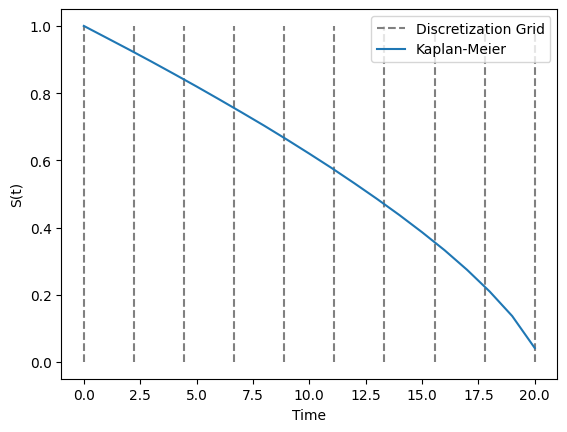

In [117]:
from pycox.utils import kaplan_meier
plt.vlines(labtrans.cuts, 0, 1, colors='gray', linestyles="--", label='Discretization Grid')
kaplan_meier(*get_target(df_train)).plot(label='Kaplan-Meier')
plt.ylabel('S(t)')
plt.legend()
_ = plt.xlabel('Time')

In [118]:
num_embeddings = x_train[1].max(0) + 1
embedding_dims = num_embeddings // 2

In [119]:
num_embeddings, embedding_dims

(2.248835802078247, 1.0)

In [120]:
in_features = x_train.shape[1]
num_nodes = [32, 32]
out_features = labtrans.out_features
batch_norm = True
dropout = 0.1

net = tt.practical.MLPVanilla(in_features, num_nodes, out_features, batch_norm, dropout)

In [121]:
net

MLPVanilla(
  (net): Sequential(
    (0): DenseVanillaBlock(
      (linear): Linear(in_features=10, out_features=32, bias=True)
      (activation): ReLU()
      (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): DenseVanillaBlock(
      (linear): Linear(in_features=32, out_features=32, bias=True)
      (activation): ReLU()
      (batch_norm): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (2): Linear(in_features=32, out_features=10, bias=True)
  )
)

In [122]:
optimizer = tt.optim.AdamWR(decoupled_weight_decay=0.01, cycle_eta_multiplier=0.8,
                            cycle_multiplier=2)
model = LogisticHazard(net, optimizer, duration_index=labtrans.cuts)# model = PMF(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)
# model = DeepHitSingle(net, tt.optim.Adam(0.01), duration_index=labtrans.cuts)

c:\Users\kavin\miniconda3\envs\pycox\lib\site-packages\torchtuples\base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwa

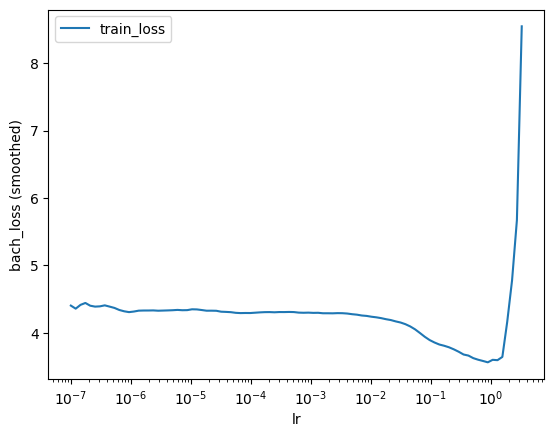

In [123]:
batch_size = 256
lrfind = model.lr_finder(x_train, y_train, batch_size, tolerance=50)
_ = lrfind.plot()

In [124]:
model.optimizer.param_groups[0]['lr']

0.08902150854450441

In [125]:
lrfind.get_best_lr()

0.08902150854450441

In [126]:
model.optimizer.set_lr(0.02)

In [127]:
epochs = 512
callbacks = [tt.cb.EarlyStoppingCycle()]
verbose = True # set to True if you want printout

In [128]:
%%time
log = model.fit(x_train, y_train, batch_size, epochs, callbacks, verbose,
                val_data=val)

0:	[7s / 7s],		train_loss: 1.7769,	val_loss: 1.7636
1:	[6s / 13s],		train_loss: 1.7635,	val_loss: 1.7637
2:	[6s / 20s],		train_loss: 1.7615,	val_loss: 1.7633
3:	[6s / 26s],		train_loss: 1.7625,	val_loss: 1.7643
4:	[6s / 32s],		train_loss: 1.7621,	val_loss: 1.7639
5:	[6s / 38s],		train_loss: 1.7616,	val_loss: 1.7633
6:	[5s / 44s],		train_loss: 1.7613,	val_loss: 1.7633
7:	[6s / 50s],		train_loss: 1.7621,	val_loss: 1.7645
8:	[6s / 56s],		train_loss: 1.7621,	val_loss: 1.7640
9:	[6s / 1m:2s],		train_loss: 1.7619,	val_loss: 1.7636
10:	[6s / 1m:8s],		train_loss: 1.7617,	val_loss: 1.7637
11:	[6s / 1m:14s],		train_loss: 1.7616,	val_loss: 1.7636
12:	[6s / 1m:21s],		train_loss: 1.7614,	val_loss: 1.7633
13:	[6s / 1m:27s],		train_loss: 1.7613,	val_loss: 1.7633
14:	[6s / 1m:33s],		train_loss: 1.7612,	val_loss: 1.7633
15:	[6s / 1m:40s],		train_loss: 1.7619,	val_loss: 1.7639
CPU times: total: 6min 27s
Wall time: 1min 40s


c:\Users\kavin\miniconda3\envs\pycox\lib\site-packages\torchtuples\base.py:669: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.net.load_state_dict(torch.load(path, **kwa

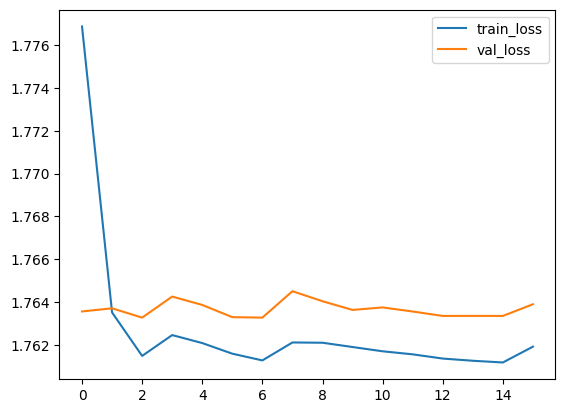

In [129]:
_ = log.plot()

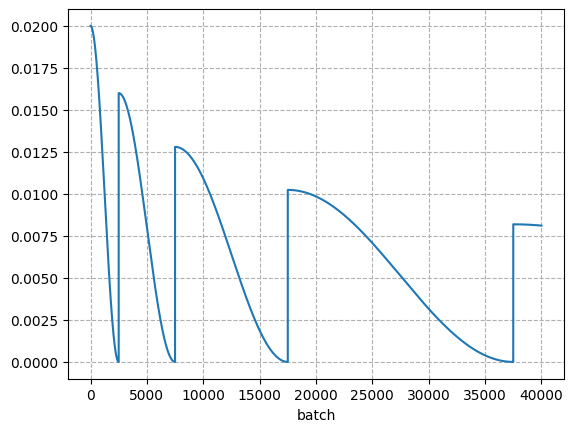

In [130]:
lrs = model.optimizer.lr_scheduler.to_pandas() * model.optimizer.param_groups[0]['initial_lr']
lrs.plot()
plt.grid(linestyle='--')

In [131]:
surv_cdi = model.interpolate(100).predict_surv_df(x_test)
surv_chi = model.interpolate(100, 'const_hazard').predict_surv_df(x_test)

In [132]:
ev_cdi = EvalSurv(surv_cdi, durations_test, events_test, censor_surv='km')
ev_chi = EvalSurv(surv_chi, durations_test, events_test, censor_surv='km')

In [133]:
ev_cdi.concordance_td(), ev_chi.concordance_td()

(0.49949865042136776, 0.4994885261337054)

In [134]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev_cdi.integrated_brier_score(time_grid), ev_chi.integrated_brier_score(time_grid)

(0.17869397677547702, 0.1790263475682262)

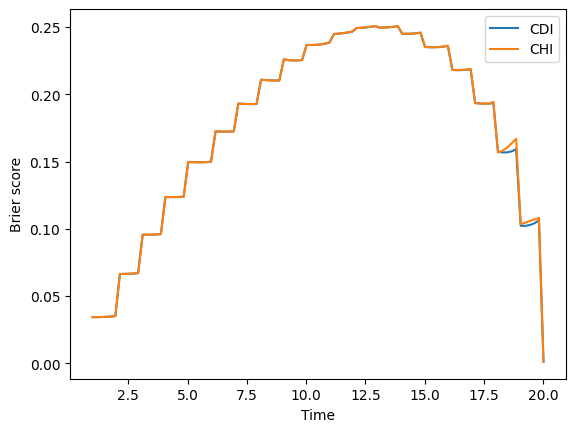

In [135]:
ev_cdi.brier_score(time_grid).rename('CDI').plot()
ev_chi.brier_score(time_grid).rename('CHI').plot()
plt.legend()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

In [136]:
log.to_pandas().val_loss.min()

1.7632688283920288

In [137]:
model.score_in_batches(val)

{'loss': 1.7632688283920288}

In [138]:
surv = model.predict_surv_df(x_test)

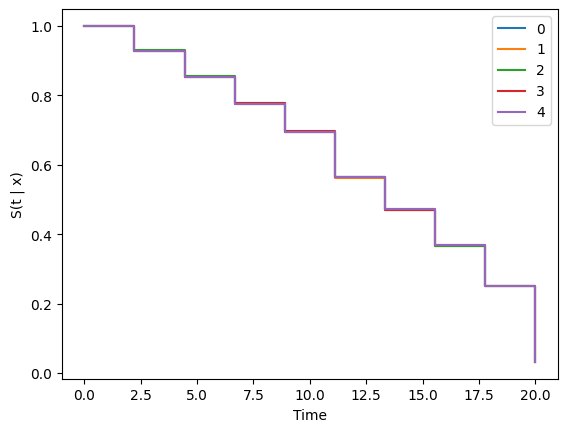

In [139]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [140]:
surv = model.interpolate(10).predict_surv_df(x_test)

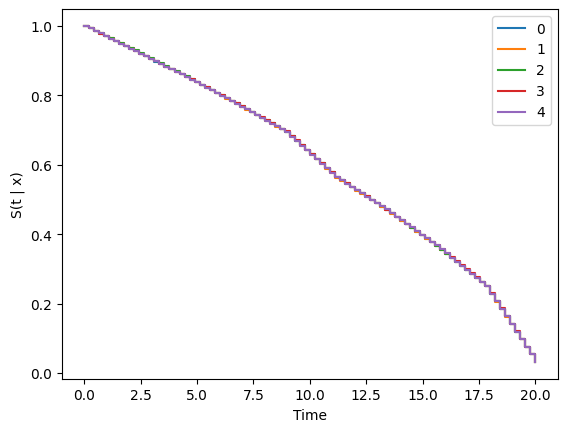

In [141]:
surv.iloc[:, :5].plot(drawstyle='steps-post')
plt.ylabel('S(t | x)')
_ = plt.xlabel('Time')

In [142]:
ev = EvalSurv(surv, durations_test, events_test, censor_surv='km')

In [143]:
ev.concordance_td('antolini')

0.499455787754761

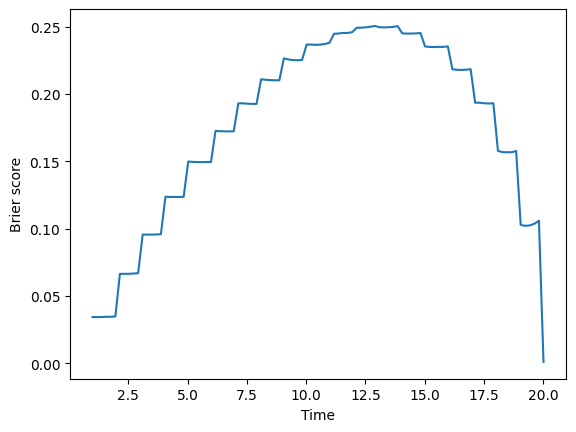

In [144]:
time_grid = np.linspace(durations_test.min(), durations_test.max(), 100)
ev.brier_score(time_grid).plot()
plt.ylabel('Brier score')
_ = plt.xlabel('Time')

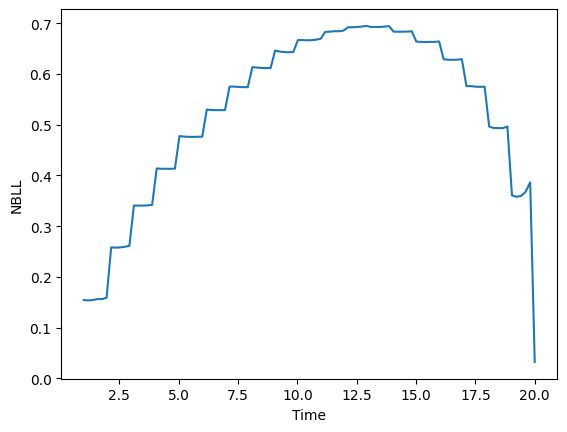

In [145]:
ev.nbll(time_grid).plot()
plt.ylabel('NBLL')
_ = plt.xlabel('Time')

In [146]:
ev.integrated_brier_score(time_grid)

0.1786454933789886

In [147]:
ev.integrated_nbll(time_grid)

0.5323310273046661